# Tutorial for dlm regression with DLMER

**In this notebook I walk through step-by-step how to read in your time-series and regressors, set-up and run the dlm, and process the outputs. If you are familiar with python it shouldn't take more than 15 minutes to read through this notebook (running the code as you go), and by the end I hope you will be geared up and ready to start running dlms on your own time-series data! So without further ado...**

## Import the required packages

In [1]:
# Import required modules
import pystan
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interpolate
import netCDF4
import pickle
import scipy.stats as stats
%matplotlib inline

# Import the dlm model

**(Note: make sure you have ran `compile_dlm_models.py` before you do this)**

In [3]:
# Import the DLM model
dlm_model = pickle.load(open('models/dlm_dynregs_ar1.pkl', 'rb'))

# Import your data

**In this example we import the BASIC stratospheric ozone composite [Ball et al 2017](https://www.research-collection.ethz.ch/handle/20.500.11850/202027) and pick out a single time-series to analyse as a demo.**

**You can load in your data however you like, but in the end you must have the following variables loaded into python:**

N (int) *the number of data points in the time-series*<br/>
d np.array(N) *the data time-series*<br/>
s np.array(N) *std-deviation error-bars on each data point*

**Note: for missing data values, you should set those data to the mean value of the rest of the data and set the corresponding error-bar for those data points to something very large - I suggest 1e20 as default.**

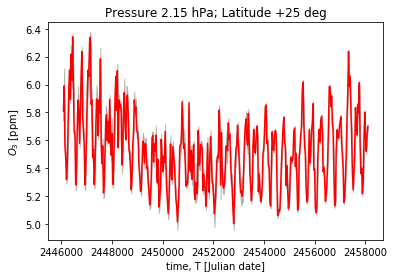

In [4]:
# Import the data 

# Import data from a netCDF
data = netCDF4.Dataset('data/BASIC_V1_2017_lotus_seascyc_gcsw2017_fac2.nc')

# Extract time, pressure and latitude variables from the netCDF
T = data['time'][:]
P = data['pressure'][:]
L = data['latitude'][:]

# Which pressure and latitude index do you want to analyze?
pressure = 22
latitude = 8

# How many time steps are there? (ie how long is the time-series)
N = len(T)

# Pick out a pressure and latitude panel: this is the "data" time-series from the netCDF
d = data['o3'][:, pressure, latitude]

# Extract the error-bars on the time-series from the netCDF
s = data['o3_sigma'][:, pressure, latitude]

# Let's plot the data with uncertainties to check it looks OK

# Plot the selected data and error bars
plt.title('Pressure {:.2f} hPa; Latitude {:+.0f} deg'.format(P[pressure], L[latitude]))
plt.plot(T, d, color = 'red')
plt.fill_between(T, d - s, d + s, color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

## Import the regressors

**Here we import some standard regressors that are provided in the `regressors/` folder, but of course you can import your own regressors here as you please. In this example I import regressor data and interpolate on to the same time-grid as the imported data.**

**Again you can import the regressors however you like, but the result must be the following variables loaded into python:**

nreg (int) *number of regressors*<br/>
regressors np.array(N, nreg) *2d array with each column representing one regressor (evaluated on the same time-grid as your data)*

**Note: Missing values/NaNs in the regressors are not currently supported, please interpolate missing values so that they are all real valued.**

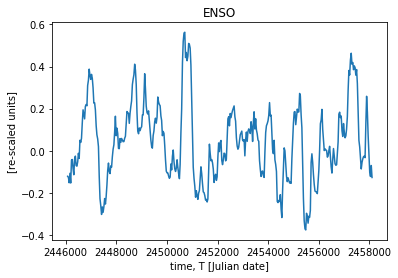

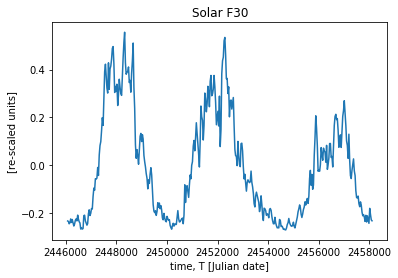

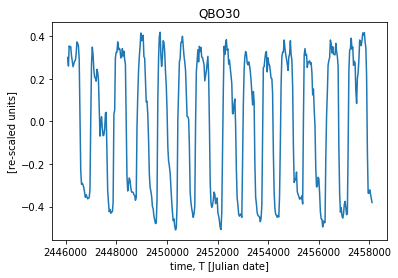

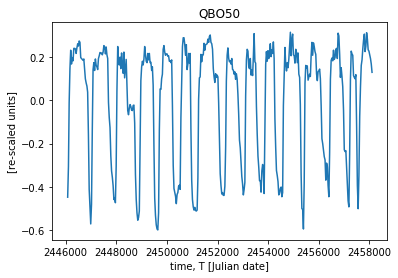

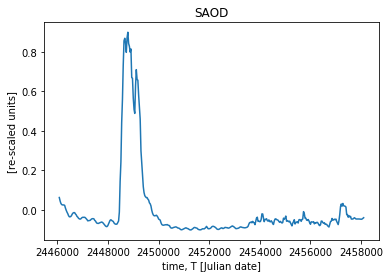

In [5]:
# Import the regressors

# ENSO
regressor_data = np.loadtxt('regressors/enso_mei_1950_201802.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
enso = Y(T)

# SOLAR
regressor_data = np.loadtxt('regressors/flux_F30_monthly_195111_201803_absolute.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
solar = Y(T)

# QBO30
regressor_data = np.loadtxt('regressors/multi_qbo30_1953_2018.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
qbo30 = Y(T)

# QBO50
regressor_data = np.loadtxt('regressors/multi_qbo50_1953_2018.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
qbo50 = Y(T)

# SAOD
regressor_data = np.loadtxt('regressors/sad_1979_2017_10deg_60S_60N.txt')
Y = interpolate.InterpolatedUnivariateSpline(regressor_data[:,0], regressor_data[:,1])
saod = Y(T)

# Stack the regressors into big 2d array
nreg = 5 # number of regressors
regressors = np.column_stack([enso, solar, qbo30, qbo50, saod]) # Stack of all the regressors together in a 2d array

# Plot all the regressors to check they look OK
plt.plot(T, enso)
plt.title('ENSO')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, solar)
plt.title('Solar F30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo30)
plt.title('QBO30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo50)
plt.title('QBO50')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, saod)
plt.title('SAOD')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

## Set the data and initialization to be fed into the dlm

**First we set the "input data" - a dictionary of all the data and input parameters than the dlm model requires. The input data must have the following entries:**

time_series np.array(N) *data vector (time-series to be analyzed)*<br/>
stddev np.array(N) standard deviation error bars for the time-series<br/>
N (int) *number of time-steps in the time-series*<br/>
nreg (int) *number of regressors*<br/>
regressors np.array(N, nreg) *the regressors*<br/>
S (float) *variance of the Gaussian prior on the regression coefficients; set to 10 as default*<br/>
sigma_trend_prior (float) *standard deviation of the half-Gaussian prior on* sigma_trend *that controls how wiggly the trend can be; set to 1e-4 as default*<br/>
sigma_seas_prior (float) *standard deviation of the half-Gaussian prior on* sigma_seas, *controls how dynamic the seaonal cycle can be; set to 0.01 as default*<br/>
sigma_AR_prior (float) *standard deviation of the half_Gaussian prior on the AR1 process's standard deviation; set to 0.5 as default*

**Second, we set the "initial state" - a dictionary of initial guesses for the hyper-parameters for initializing the MCMC sampler. This must have the following entries (with sugegsted default values):**

sigma_trend (float) *initial value for* sigma_trend; *default to 0.0001*<br/>
sigma_seas (float) *initial value for* sigma_seas; *default to 0.001*<br/>
sigma_AR (float) *initial value for* sigma_AR; *default to 0.01*<br/>
rhoAR (float) *initial value for* rhoAR; *default to 0.1*<br/>               

In [25]:
# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d, # float[N] data vector
                    'stddev':s, # float[N] std-dev error bars
                    'N':N, # (int) number of time-steps in the time-series
                    'nreg':nreg, # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'S':10., # prior variance on the regression coefficients
                    'sigma_trend_prior':1e-4, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':0.01, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':0.5, # std-dev of the half_Gaussian prior on the AR1 process std-dev
                    'sigma_reg_prior':np.ones(nreg)*0.01 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':0.0001,
                 'sigma_seas':0.001,
                 'sigma_AR':0.01,
                 'rhoAR':0.1,
                 'sigma_reg':np.ones(nreg)*0.01
                }

## OK let's run the DLM!

**Now we're set up we can run the dlm. Below we run an HMC sampler (using `pystan`) to obtain samples from the posterior of the dlm model parameters given the input data and uncertainties, ie., generating samples from the joint distribution:**

$P(nonlinear\;trend,\,seasonal\;cycle,\,AR\;process,\,regressor\;coefficients,\,hyperparameters | data)$

**The input parameters to the function "sampling()" below have the following meanings:**

data = *input data dictionary from above*<br/>
iter = *total number of MCMC samples to get; should be at least a few thousand*<br/>
warmup = *how many evaluations are allowed for the HMC sampler to "warm-up" (these are discarded in the final output)*<br/>
chains = *how many parallel chains to run? (see below for running parallel chains)*<br/>
init = *list of initial state dictionaries (from above), one per chain*<br/>
pars = *which parameters do you actually want to save as output in the results? (see below)*

**The "pars" parameter controls which parameters you want to save in the output results. You can choose any number from the following:**

sigma_trend (float) *hyper-parameter controlling how wiggly the trend can be*<br/>
sigma_seas (float) *hyper-parameter controlling how dynamic the seasonal cycle can be*<br/>
sigma_AR (float) *standard deviation parameter for the AR process*<br/>
rhoAR (float) *correlation parameter for the AR process*<br/>
beta np.array(nreg) *regression coefficients*<br/>
trend np.array(N) *non-inear DLM trend (as function of time)*<br/> 
slope np.array(N) *slope of the non-linear DLM trend (as function of time)*<br/>
seasonal np.array(N) *seasonal cycle with 6- and 12- month components (as function of time)*<br/>
ar np.array(N) *fitted AR1 process (as function of time)*

**NOTE: you should limit your output "pars" to things you really want to look at after to keep the output smaller - it will be faster to work with for making plots etc later on, and take up less memory. If you do not set pars it will automatically save everything by default.**

**Running multiple chains in parallel: It is easy to run multiple chains in parallel by simply setting chains > 1. If you do this you must also provide a list of initial state dictionaries to "init", ie., init = [initial_state1, initial_state2, ...] (precicely one initial state per chain, and they need not be different although it is good practice to give the chains different starting points)**

**OK let's do it! NB it will take a few minutes to run so be patient**

In [26]:
# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=3000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR', 'trend', 'slope', 'beta', 'seasonal', 'sigma_reg'))

## Extract the results

**By this point, the "fit" object contains samples of each of the "pars" that you chose to output. To access the samples for any individual parameter, just do:**

parameter_samples = fit.extract()['insert parameter name here'] (see examples below)

**For example, if you do fit.extract()['trend'] it will give an array np.array(chains x iter, N), ie chains x iter
samples of the full DLM trend, which has lengh N.**

**All outputs from the fit object will have shape n_samples x object_dimension, where the number of samples
n_samples = iter x chains and object_dimension is the length of the object, eg. =1 for scalars like sigma_AR 
and = N (n_time_steps) for objects that have a real value at all time steps like the DLM trend, seasonal cycle, etc.**

**To make life easier for anlysing the results in the rest of the notebook, let's extract all the samples here in one go...**


In [27]:
# Extract the various bits from the fit-object. 

# Trend
trend = fit.extract()['trend'][:,:]

# Gradient of the DLM trend
slope = fit.extract()['slope'][:,:]

# Seasonal cycle
seasonal_cycle = fit.extract()['seasonal'][:,:]

# Regressor coefficients (also need re-scaling back to data units)
regressor_coefficients = fit.extract()['beta'][:,:]

# DLM hyper parameters
sigma_trend = fit.extract()['sigma_trend']
sigma_seas = fit.extract()['sigma_seas']
sigma_AR = fit.extract()['sigma_AR']
rho_AR = fit.extract()['rhoAR']
sigma_reg = fit.extract()['sigma_reg'][:,:]

## Finally, let's make some plots of the outputs!

**Obviously we can compute and plot whatever we like now we have the results, but let's make a few example plots of the various parameters we have inferred to showcase the results.**

### Let's start by plotting the recovered dlm trend and corresponding (1$\sigma$) uncertainties:

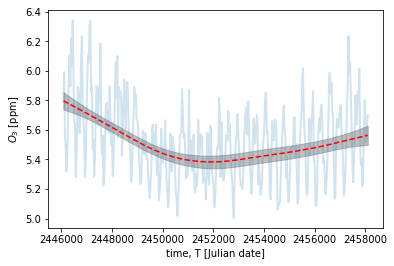

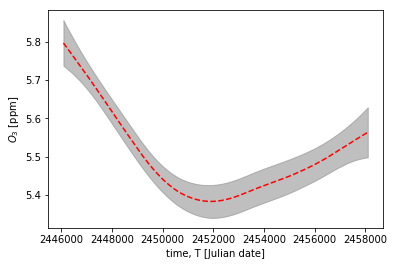

In [28]:
# Plot recovered trend against the data

# Plot the data
plt.plot(T, d, lw = 2, alpha = 0.2)

# Plot the mean trend
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')

# Plot a grey band showing the error on the extracted DLM trend
# NOTE: this includes the error on the shape of the trend, but also on the overall offset, so can look deceptively large
plt.fill_between(T, np.mean(trend, axis = 0) - np.std(trend, axis = 0), np.mean(trend, axis = 0) + np.std(trend, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

# Same plot but without the data behind (for a closer look at the DLM trend)
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')
plt.fill_between(T, np.mean(trend, axis = 0) - np.std(trend, axis = 0), np.mean(trend, axis = 0) + np.std(trend, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

### We can also plot the recovered slope of the trend as a function of time (negative slope indicates ozone depletion, positive slope indicates recovery):

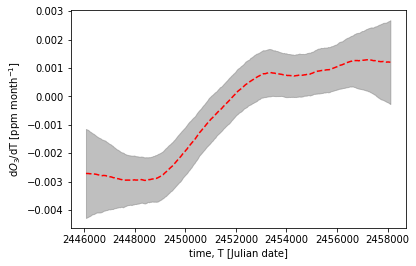

In [29]:
# Plot the slope of the recovered trend
plt.plot(T, np.mean(slope, axis = 0), color = 'red', ls = '--')
plt.fill_between(T, np.mean(slope, axis = 0) - np.std(slope, axis = 0), np.mean(slope, axis = 0) + np.std(slope, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'd$O_3$/dT [ppm month$^{-1}$]')
plt.show()

### Now for the recovered seasonal cycle - note that modulation in the amplitude of the seasonal cycle is allowed in the dlm model (and here is preferred by the data):

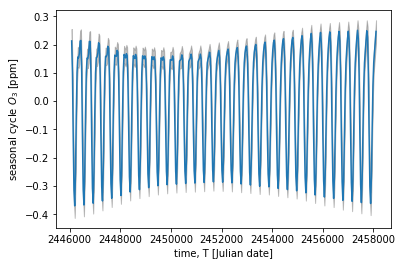

In [30]:
# Plot the recovered seasonal cycle and uncertainties
plt.plot(T, np.mean(seasonal_cycle, axis = 0))
plt.fill_between(T, np.mean(seasonal_cycle, axis = 0) - np.std(seasonal_cycle, axis = 0), np.mean(seasonal_cycle, axis = 0) + np.std(seasonal_cycle, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel('seasonal cycle $O_3$ [ppm]')
plt.show()

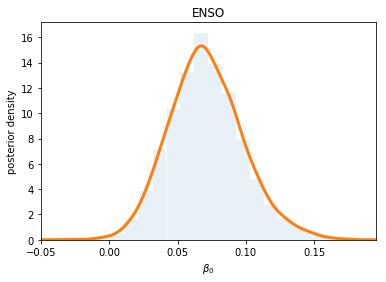

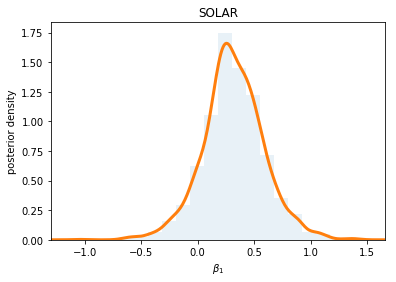

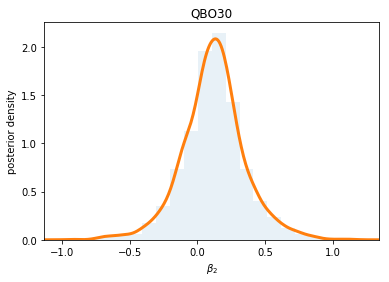

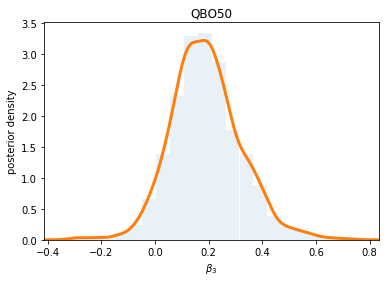

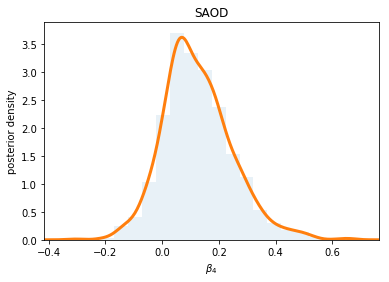

In [31]:
# Plot posteriors for the regression coefficients
regressor_names = ['ENSO', 'SOLAR', 'QBO30', 'QBO50', 'SAOD']
for i in range(nreg):
    beta = regressor_coefficients[:,i]
    kde = stats.gaussian_kde(beta)
    x = np.linspace(min(beta) - np.ptp(beta)*0.1, max(beta) + np.ptp(beta)*0.1, 300)
    plt.hist(beta, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3)
    plt.xlim(x[0], x[-1])
    plt.title(regressor_names[i])
    plt.ylabel('posterior density')
    plt.xlabel(r'$\beta_{}$'.format(i))
    plt.show()

### We can also plot histograms of the dlm hyper-parameter posteriors:

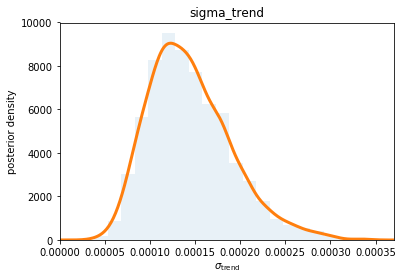

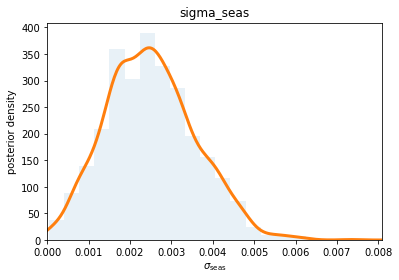

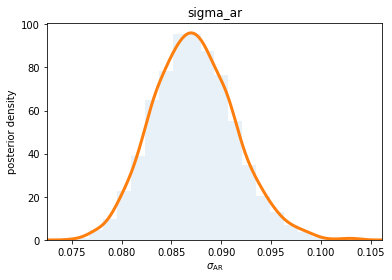

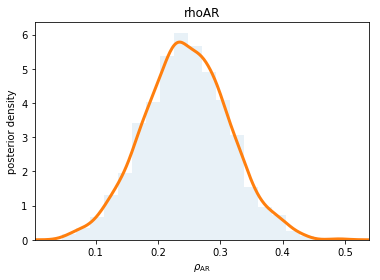

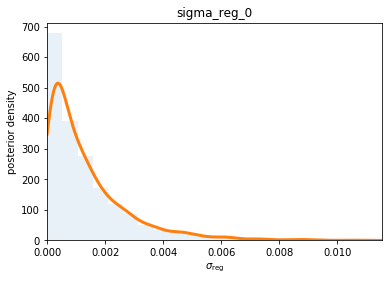

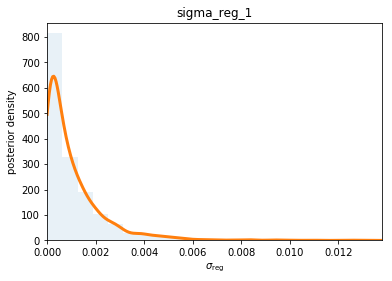

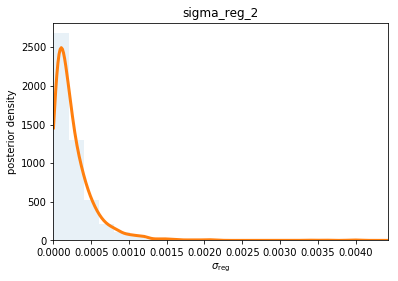

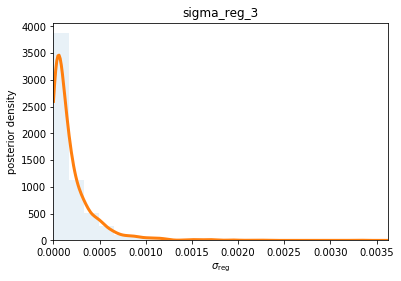

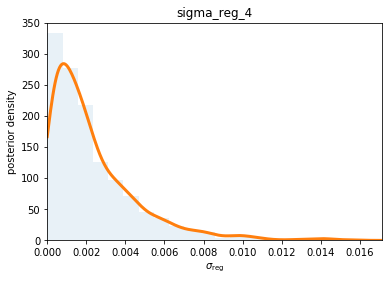

In [32]:
# Plot posteriors for the DLM hyper parameters
kde = stats.gaussian_kde(sigma_trend)
x = np.linspace(0, max(sigma_trend)*1.1, 300)
plt.hist(sigma_trend, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.show()

kde = stats.gaussian_kde(sigma_seas)
x = np.linspace(0, max(sigma_seas)*1.1, 300)
plt.hist(sigma_seas, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.show()

kde = stats.gaussian_kde(sigma_AR)
x = np.linspace(min(sigma_AR) - np.ptp(sigma_AR)*0.1, max(sigma_AR) + np.ptp(sigma_AR)*0.1, 300)
plt.hist(sigma_AR, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_ar')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.show()

kde = stats.gaussian_kde(rho_AR)
x = np.linspace(min(rho_AR) - np.ptp(rho_AR)*0.1, max(rho_AR) + np.ptp(rho_AR)*0.1, 300)
plt.hist(rho_AR, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('rhoAR')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR}$')
plt.show()

for i in range(nreg):
    kde = stats.gaussian_kde(sigma_reg[:,i])
    x = np.linspace(0, max(sigma_reg[:,i])*1.1, 300)
    plt.hist(sigma_reg[:,i], bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3)
    plt.xlim(x[0], x[-1])
    plt.title('sigma_reg_{}'.format(i))
    plt.ylabel('posterior density')
    plt.xlabel(r'$\sigma_\mathrm{reg}$')
    plt.show()

### Now for some trace plots of the MCMC samples of the hyper-parameters:

### This provides a good visual check of whether the chains have converged - if they look like noise it indicates that the chains are well converged, whilst if you see drifts in these trace plots then you need to go back and run longer chains (ie increase "iter" in the sampling() step above).

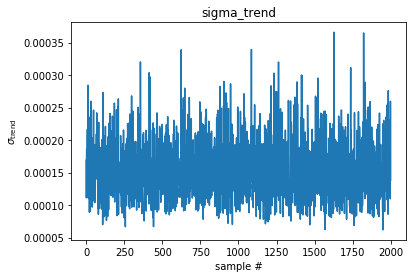

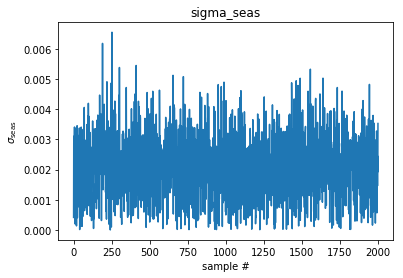

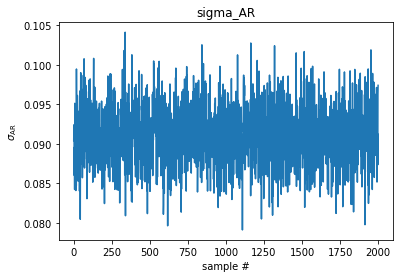

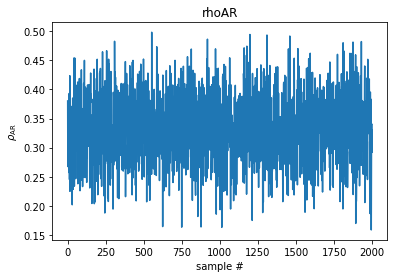

In [16]:
# Do trace plots of the MCMC chains of the hyper-parameters

plt.plot(sigma_trend)
plt.title('sigma_trend')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{trend}$')
plt.show()

plt.plot(sigma_seas)
plt.title('sigma_seas')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{seas}$')
plt.show()

plt.plot(sigma_AR)
plt.title('sigma_AR')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{AR}$')
plt.show()

plt.plot(rho_AR)
plt.title('rhoAR')
plt.xlabel('sample #')
plt.ylabel(r'$\rho_\mathrm{AR}$')
plt.show()

### Finally, we can do things like plot the posterior for the net background change in ozone between two key dates (here, January 1998 and December 2017)

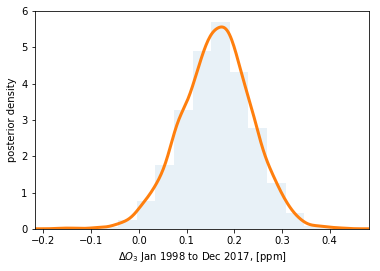

In [33]:
# Plot the posterior on the overall change in O3 between two dates eg, jan1998 and dec2017

# Time indices for the two dates
jan1998 = 156 # index of the T array corresponding to Jan 1998
dec2017 = -1 # (end of time series; december 2017)

# Construct MCMC samples for the change in O3 between those two dates by differencing the trend samples at those dates
deltaO3_jan1998_dec2017 = trend[:,dec2017] - trend[:,jan1998]

# Plot the histogram of the posterior samples of DeltaO3 between Jan 1998 and Dec 2017
kde = stats.gaussian_kde(deltaO3_jan1998_dec2017)
x = np.linspace(min(deltaO3_jan1998_dec2017) - np.ptp(deltaO3_jan1998_dec2017)*0.1, max(deltaO3_jan1998_dec2017) + np.ptp(deltaO3_jan1998_dec2017)*0.1, 300)
plt.hist(deltaO3_jan1998_dec2017, bins = 15, alpha = 0.1, density = True)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.xlabel(r'$\Delta O_3$ Jan 1998 to Dec 2017, [ppm]')
plt.ylabel('posterior density')
plt.show()

### Congratulations, you made it to the end of the tutorial! By now you should get the idea and, I hope, be able to use this notebook as a template for performing dlm regression on your own data!